In [1]:
import sys

sys.path.append("../..")
sys.path.append("../../../py-pde")

import logging

logging.basicConfig(level=logging.INFO)

from tqdm.auto import tqdm

import numba as nb
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from matplotlib import cm

In [2]:
from multicomp import *

In [3]:
f = FloryHuggins.from_random_normal(20, 2, 5)

In [4]:
m = MultiphaseSystem.from_random_composition(f, 20)
# m = MultiphaseSystem.demixed_composition(f, c_dense=0.75)

In [5]:
[f.is_stable(c) for c in m.phis]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [6]:
class RelaxationDynamics2(RelaxationDynamics):
    maxiter = 100
    maxerror = 1e-4

    def evolve_implicit(
        self,
        t_range,
        dt=1e-5,
        *,
        method="explicit",
        interval=1.0,
        tolerance=1e-5,
        progress=True,
        save_intermediate_data=False,
    ):
        """use explicit Euler method to evolve ODEs

        Args:
            t_range:
                The time for which the simulation is maximally run. It might abort
                earlier when the stationary state is reached.
            dt:
                The initial time step. This time step will be automatically reduced when
                the simulation has trouble advancing.
            interval:
                The time interval at which convergence is checked (and data is saved if
                `save_intermediate_data` is True.
            tolerance:
                The tolerance determining when the simulation will be aborted because
                the algorithm thinks we reached the stationary state
            progress:
                Flag determining whether to show a progress bar during the simulation.
            save_intermediate_data:
                Flag determining whether saving (and returning) data in time intervals
                determined by `interval`

        Returns:
            tuple: Simulation time and mixture. If `save_intermediate_data == True`,
            these are lists with all the saved data. Otherwise, only the last time point
            is returned.
        """
        steps_tracker = int(np.ceil(t_range / interval))
        steps_inner = int(np.ceil(t_range / dt)) // steps_tracker
        tol = tolerance * interval
        rhs = self._make_evolution_rate()

        chis = self.mixture.free_energy.chis

        maxiter = int(self.maxiter)
        maxerror2 = float(self.maxerror**2)

        @nb.njit
        def iterate_inner(phis, dt, steps):
            """helper function doing multiple iterations"""
            for _ in range(steps):
                # estimate state at next time point
                evolution_last = dt * rhs(phis, chis)

                for n in range(maxiter):
                    # fixed point iteration for improving state after dt
                    phis_guess = phis + evolution_last
                    evolution_this = dt * rhs(phis_guess, chis)

                    # calculate mean squared error
                    err = 0.0
                    for j in range(phis.size):
                        err += (
                            phis_guess.flat[j] - phis.flat[j] - evolution_this.flat[j]
                        ) ** 2
                    err /= phis.size

                    if err < maxerror2:
                        # fix point iteration converged
                        break

                    evolution_last = evolution_this
                else:
                    with nb.objmode:
                        print(
                            "Implicit Euler step did not converge after %d iterations "
                            "at t=%g (error=%g)",
                            maxiter,
                            t,
                            err,
                        )
                    raise RuntimeError("Implicit Euler step did not converge.")
                phis += evolution_this

            return dt * steps

        it = range(steps_tracker)
        if progress:
            it = tqdm(it)

        t = 0
        num_steps = 0
        phis = self.mixture.phis.copy()  # do not change initial value
        mixtures = []
        times = []
        for _ in it:
            # store result
            if save_intermediate_data:
                times.append(t)
                mixtures.append(self.mixture.copy(phis))
                phis_last = mixtures[-1].phis
            else:
                phis_last = phis.copy()

            # do the inner steps
            while True:
                try:
                    t_inner = iterate_inner(phis, dt, steps_inner)
                except RuntimeError:
                    # problems in the simulation => reduced dt and reset phis
                    dt /= 2
                    steps_inner *= 2
                    phis = phis_last.copy()

                    self._logger.info(f"Reduced time step to {dt}")
                    if dt < 1e-7:
                        raise RuntimeError("Time step became too small")
                else:
                    # step seemed to be ok
                    t += t_inner
                    num_steps += steps_inner
                    break

            # check distance and abort simulations if things do not change much
            if np.allclose(phis, phis_last, rtol=tol, atol=tol):
                self._logger.info("Simulation converged")
                break

        # add final data point
        if not times or times[-1] != t:
            times.append(t)
            mixtures.append(self.mixture.copy(phis))

        # store diagnostic output
        self.diagnostics = {
            "num_steps": num_steps,
            "steps_tracker": steps_tracker,
            "dt_last": dt,
        }

        if save_intermediate_data:
            return np.array(times), mixtures
        else:
            return times[0], mixtures[0]

In [7]:
r = RelaxationDynamics2(m)

In [8]:
rhs = r._make_evolution_rate()
np.allclose(r.evolution_rate(), rhs(m.phis))

True

In [9]:
ts1, res1 = r.evolve(1e2, dt=1, save_intermediate_data=True)
r.diagnostics

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:RelaxationDynamics2:Reduced time step to 0.5
INFO:RelaxationDynamics2:Reduced time step to 0.25
INFO:RelaxationDynamics2:Reduced time step to 0.125
INFO:RelaxationDynamics2:Reduced time step to 0.0625
INFO:RelaxationDynamics2:Reduced time step to 0.03125
INFO:RelaxationDynamics2:Reduced time step to 0.015625
INFO:RelaxationDynamics2:Reduced time step to 0.0078125
INFO:RelaxationDynamics2:Reduced time step to 0.00390625


{'num_steps': 25600, 'steps_tracker': 100, 'dt_last': 0.00390625}

In [10]:
ts2, res2 = r.evolve_implicit(1e2, dt=1, save_intermediate_data=True)
r.diagnostics

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:RelaxationDynamics2:Reduced time step to 0.5
INFO:RelaxationDynamics2:Reduced time step to 0.25
INFO:RelaxationDynamics2:Reduced time step to 0.125
INFO:RelaxationDynamics2:Reduced time step to 0.0625
INFO:RelaxationDynamics2:Reduced time step to 0.03125
INFO:RelaxationDynamics2:Reduced time step to 0.015625
INFO:RelaxationDynamics2:Reduced time step to 0.0078125
INFO:RelaxationDynamics2:Reduced time step to 0.00390625
INFO:RelaxationDynamics2:Reduced time step to 0.001953125
INFO:RelaxationDynamics2:Reduced time step to 0.0009765625
INFO:RelaxationDynamics2:Reduced time step to 0.00048828125


Implicit Euler step did not converge after %d iterations at t=%g (error=%g) 100 0 2.4098033024004612e-08


{'num_steps': 201728, 'steps_tracker': 100, 'dt_last': 0.00048828125}

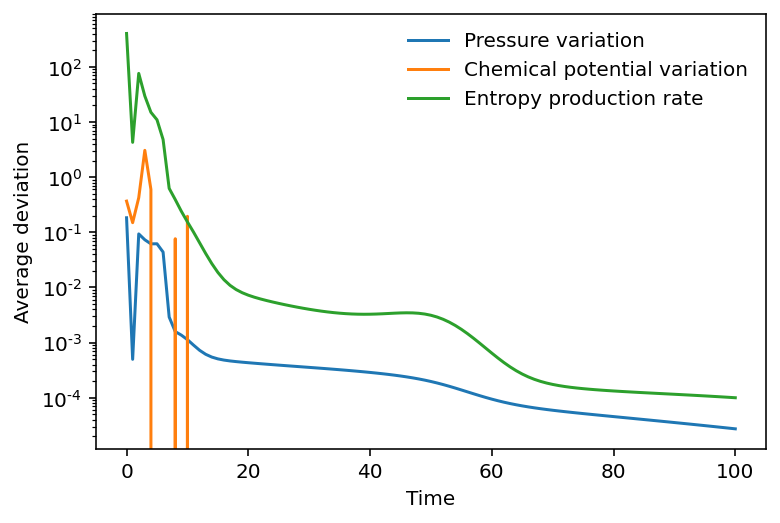

In [11]:
plot_convergence(ts1, res1)

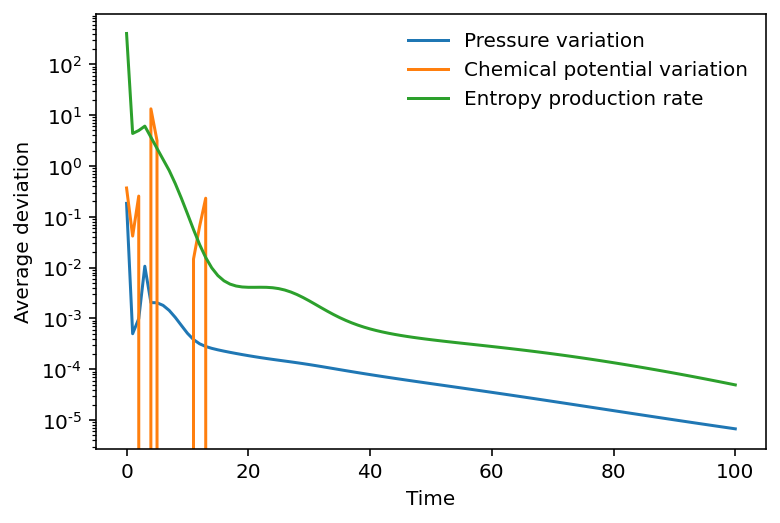

In [12]:
plot_convergence(ts2, res2)

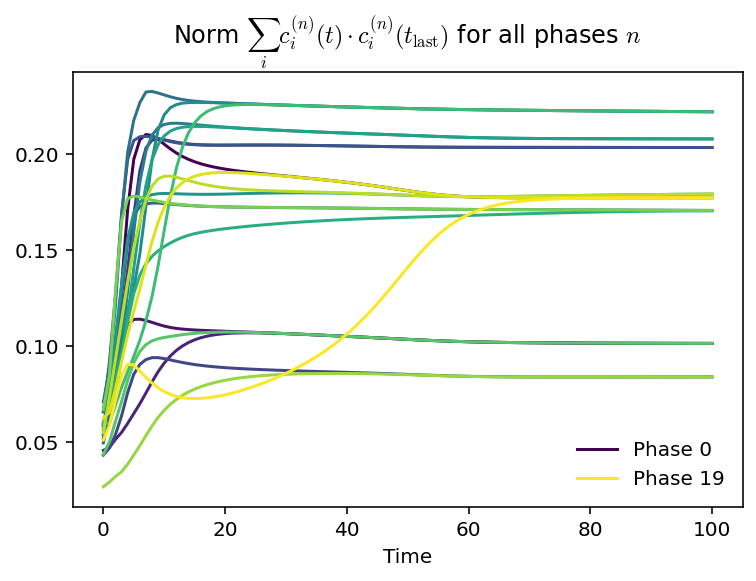

In [13]:
plot_concentrations(ts1, res1)

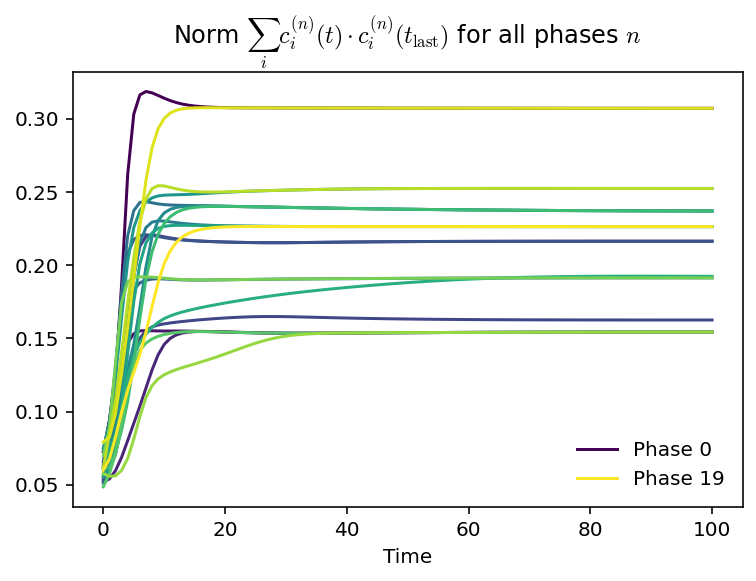

In [14]:
plot_concentrations(ts2, res2)

In [17]:
res1[-1].count_clusters(), res2[-1].count_clusters()

(9, 9)